In [1]:
!pip install nibabel

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/protocol.py", line 36

In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, SimpleRNN, LSTM,Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D,Conv2DTranspose,Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model



In [3]:
import nibabel as nib
import numpy as np

def load_streamlines(dataPath, subject_ids, bundles, n_tracts_per_bundle):
    X = []
    y = []
    for i in range(len(subject_ids)):
        for c in range((len(bundles))):
            filename = dataPath + subject_ids[i] + '/' + bundles[c] + '.trk' 
            tfile = nib.streamlines.load(filename)
            streamlines = tfile.streamlines

            n_tracts_total = len(streamlines)
            ix_tracts = np.random.choice(range(n_tracts_total), n_tracts_per_bundle, replace=False)

            streamlines_data = streamlines.get_data()
            streamlines_offsets = streamlines._offsets
            for j in range(n_tracts_per_bundle):
                ix_j = ix_tracts[j]
                offset_start = streamlines_offsets[ix_j] 
                if ix_j < (n_tracts_total - 1):
                    offset_end = streamlines_offsets[ix_j + 1]
                    streamline_j = streamlines_data[offset_start:offset_end] 
                else:
                    streamline_j = streamlines_data[offset_start:] 
                X.append(np.asarray(streamline_j))
                y.append(c)
    return X, y


In [4]:
dataPath = '/DL_course_data/Lab5/HCP_lab/'
train_subjects_list = ['599469','599671','601127']
val_subjects_list = ['613538']
n_tracts_per_bundle = 20

bundles_list = ['CST_left', 'CST_right']
X_train, y_train = load_streamlines(dataPath, train_subjects_list, bundles_list, n_tracts_per_bundle)
X_val, y_val = load_streamlines(dataPath, val_subjects_list, bundles_list, n_tracts_per_bundle)

In [18]:
def model(units):
    model = Sequential()
    # Add four LSTM layers
    # batch_shape// inputs
    model.add(Bidirectional(LSTM(units, return_sequences=True, stateful = True),batch_input_shape=(1,None, 3)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=units, return_sequences= True, stateful = True ))
    model.add(Dropout(0.2))

    model.add(LSTM(units=units, return_sequences= True, stateful = True ))
    model.add(Dropout(0.2))

    model.add(LSTM(units=units, return_sequences= False, stateful = True ))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation='softmax'))
    model.summary()

    return model

In [6]:
from tensorflow.keras.utils import Sequence 
class MyBatchGenerator(Sequence):
    def __init__(self, X, y, batch_size=1, shuffle=True):
        self.X = X 
        self.y = y
        self.batch_size = batch_size 
        self.shuffle = shuffle 
        self.on_epoch_end()
    def __len__(self):
        'Get number of batches per epoch'
        return int(np.floor(len(self.y)/self.batch_size))
    def __getitem__(self, index):
        return self.__data_generation(index)
    def on_epoch_end(self):
        'Shuffle indexes after each epoch' 
        self.indexes = np.arange(len(self.y)) 
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __data_generation(self, index):
        Xb = np.empty((self.batch_size, *self.X[index].shape)) 
        yb = np.empty((self.batch_size, 1))
        for s in range(0, self.batch_size):
            Xb[s] = self.X[index]
            yb[s] = self.y[index] 
        return Xb, yb

In [7]:
n_epochs = 50
LR = 1e-3
model = model(5)
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = LR), metrics=['mean_absolute_error'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (1, None, 20)            1120      
 l)                                                              
                                                                 
 dropout (Dropout)           (1, None, 20)             0         
                                                                 
 lstm_1 (LSTM)               (1, None, 10)             1240      
                                                                 
 dropout_1 (Dropout)         (1, None, 10)             0         
                                                                 
 lstm_2 (LSTM)               (1, None, 10)             840       
                                                                 
 dropout_2 (Dropout)         (1, None, 10)             0         
                                                        

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
model_history = model.fit_generator(MyBatchGenerator(X_train, y_train, batch_size=1), 
                epochs=n_epochs, validation_data=MyBatchGenerator(X_val, y_val, batch_size=1), 
                validation_steps=len(X_val))
 

Epoch 1/50


<ipython-input-8-afd94a822aa3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(MyBatchGenerator(X_train, y_train, batch_size=1),


120/120 [==============================] - 7s 18ms/step - loss: 0.7020 - mean_absolute_error: 0.5000 - val_loss: 0.6939 - val_mean_absolute_error: 0.5000
Epoch 2/50
120/120 [==============================] - 1s 8ms/step - loss: 0.7261 - mean_absolute_error: 0.5000 - val_loss: 0.6979 - val_mean_absolute_error: 0.5000
Epoch 3/50
120/120 [==============================] - 1s 8ms/step - loss: 0.7388 - mean_absolute_error: 0.5000 - val_loss: 0.6972 - val_mean_absolute_error: 0.5000
Epoch 4/50
120/120 [==============================] - 1s 8ms/step - loss: 0.7768 - mean_absolute_error: 0.5000 - val_loss: 0.6943 - val_mean_absolute_error: 0.5000
Epoch 5/50
120/120 [==============================] - 1s 9ms/step - loss: 0.7781 - mean_absolute_error: 0.5000 - val_loss: 0.6947 - val_mean_absolute_error: 0.5000
Epoch 6/50
120/120 [==============================] - 1s 10ms/step - loss: 0.8090 - mean_absolute_error: 0.5000 - val_loss: 0.6934 - val_mean_absolute_error: 0.5000
Epoch 7/50
120/120 [=====

In [11]:
model_history

In [14]:
def show_hist(History): 
    plt.figure(figsize=(3, 3))
    plt.title("Learning curve")
    plt.plot(History.history["loss"], label="loss")
    plt.plot(History.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(History.history["val_loss"]),
            np.min(History.history["val_loss"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.legend()
    plt.show()

    plt.figure

    plt.figure(figsize=(3, 3))
    plt.title("dice_coef")
    plt.plot(History.history["mean_absolute_error"], label="mean_absolute_error")
    plt.plot(History.history["val_mean_absolute_error"], label="val_mean_absolute_error")
    plt.plot( np.argmax(History.history["val_mean_absolute_error"]),
            np.max(History.history["val_mean_absolute_error"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("dice_coef")
    plt.legend()
    plt.show()


In [13]:
print(model_history.history.keys())


dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


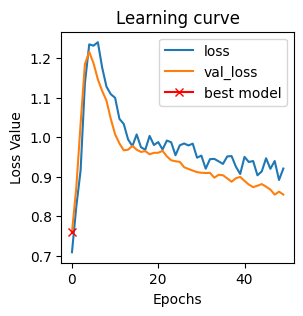

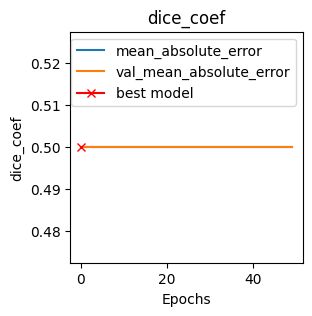

In [20]:
show_hist(model_history)